In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
from IPython import display
import pandas as pd

from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk
from gpr4im import obs_tools as obs

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Power spectrum bias correction

Here we will look at the Florent Mertens et al. 2020 (M20; https://arxiv.org/pdf/2002.07196.pdf) method of unbiasing the recovered power spectrum of the GPR residual (the signal left after performning foreground removal).

M20 use a Monte Carlo procedure to do this correction (this is the __analytic FG error__):
1. First, draw a lot of random realisation of the data described by the foreground covariance (`fg_cov`)
2. Measure the power spectrum of each of these realisations
3. Average these power spectra
4. Add the averaged power spectrum to the residual power spectrum

This correction assumes we know our data covariance, i.e. that the estimated 21cm covariance found by GPR is the real one, and the same for the foregrounds. If this is not the case, it can lead to an overprediction or underprediction of the 21cm power spectrum, depending on whether the 21cm covariance is overpredicted or underpredicted.

This analytic correction should be equivalent to subtracting the foreground prediction from the true foreground signal (this is the __actual FG error__).

_The analytic and actual FG errors should be very similar._

Florent Mertens demonstrates both of these bias corrections (analysic and actual) in this notebook, which is a part of his public code `ps_eor`: https://gitlab.com/flomertens/ps_eor/-/blob/master/doc/GPR%20theory%20and%20practice.ipynb

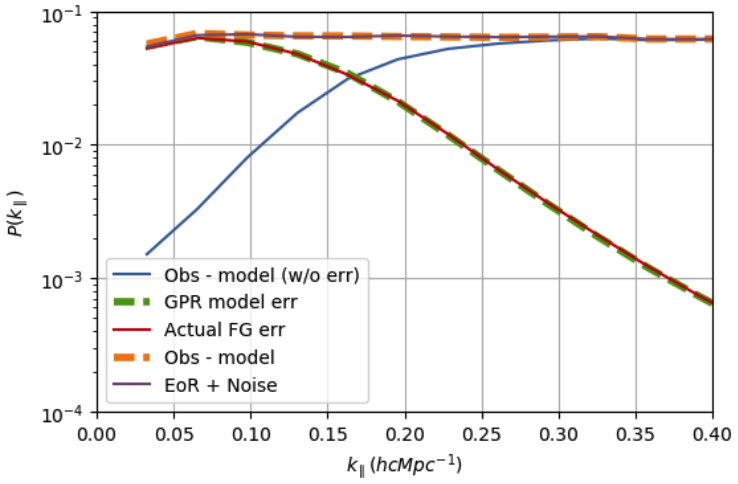

In [3]:
display.Image("images/Mertens_bias_correction.png")

## Loading data

We consider here the case of no polarised foregrounds.

In [4]:
data = pd.read_pickle('../Data/example_data.pkl')
FGnopol_HI_noise_data = data.beam.FGnopol_HI_noise
FGnopol_data = data.beam.FGnopol
HI_noise_data = data.beam.HI_noise
freqs = data.freqs

## Running GPR foreground removal (see `Running GPR.ipynb`)

Setting kernels for the different signals (RBF for smooth foregrounds, Exponential for 21cm and noise combined), and their priors.

In [5]:
# kernel for the smooth foreground:
kern_fg = GPy.kern.RBF(1)
kern_fg.variance.constrain_bounded(1000,100000000)
kern_fg.lengthscale.constrain_bounded(200,10000)
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)
kern_21.variance.constrain_bounded(0.000001,0.5)
kern_21.lengthscale.constrain_bounded(0.01,15)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters Exponential.lengthscale


Running the GPR cleaning function, to obtain `gpr_result`, a pandas Series that contains:
- `res`: the residual foreground removed data
- `fgcov`: the foreground covariance (error in the foreground fit), used for the bias correction
- `model`: the optimised GPR model
- `fgfit`: the foreground fit, which is removed from the data to yield the residual `gpr_res`

In [6]:
Input = FGnopol_HI_noise_data
gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, NprePCA=0, num_restarts=10, 
                                      noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)
# this extracts the foreground fit and its "error covariance":
fg_fit, fg_cov = gpr_result.fgfit, gpr_result.fgcov

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -5728921.8103311695
Optimization restart 2/10, f = -5744408.883760818
Optimization restart 3/10, f = -5744408.894621668
Optimization restart 4/10, f = -5744408.886377154
Optimization restart 5/10, f = -5728923.221900571
Optimization restart 6/10, f = -5637909.118196694
Optimization restart 7/10, f = -5728925.113860561
Optimization restart 8/10, f = -5744408.869845601
Optimization restart 9/10, f = -5639844.425345095
Optimization restart 10/10, f = -5728924.477327077


Printing the model:

In [7]:
gpr_result.model

GP_regression.,value,constraints,priors
sum.rbf.variance,16778.72311083932,"1000.0,100000000.0",
sum.rbf.lengthscale,457.4696795280905,"200.0,10000.0",
sum.Exponential.variance,0.0010005331393595858,"1e-06,0.5",
sum.Exponential.lengthscale,5.57494130788844,"0.01,15.0",
Gaussian_noise.variance,0.0,+ve fixed,


Let's take a look at the foreground covariance and what it looks like:

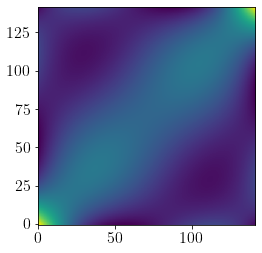

In [8]:
plt.imshow(fg_cov, origin='lower')

Let's also look at what the foreground residuals (`fg_res`) look like. These are the foreground data minus the foreground fit (`fg_fit`). It looks similar but not exactly the same as above - there are some off diagonal components that we don't see in the foreground covariance.

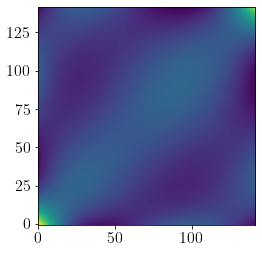

In [9]:
fg_res = FGnopol_data - fg_fit
fg_cov_actual = np.cov(obs.LoSpixels(fg_res))

plt.imshow(fg_cov_actual, origin='lower')

As demonstrated in Section 3.3.2 of M20, there is a bias correction we must apply to the recovered residual covariance, assuming we know the data covariance perfectly. We quote this section below.

Notation:

- $\textbf{d}$ is our observed data, composed of the foregrounds $(\textbf{f}_\text{fg})$, HI signal $(\textbf{f}_\text{21})$ and noise $(\textbf{n})$
- $\xi(\textbf{f}_\text{fg})$ is the foreground expectation value (`fg_fit`)
- cov($\textbf{f}_\text{fg}$) is the covariance on the foreground fit (`fg_cov`). Note, this is not the frequency covariance of the foreground expected value, it's essentially the error on the expected value due to the kernel being an imperfect fit.
- $\textbf{r}$ is the residual HI and noise signal, obtained after foreground removal: $\textbf{r} = \textbf{d} - \xi(\textbf{f}_\text{fg})$ (equivalent to `res = Input - fg_fit`)

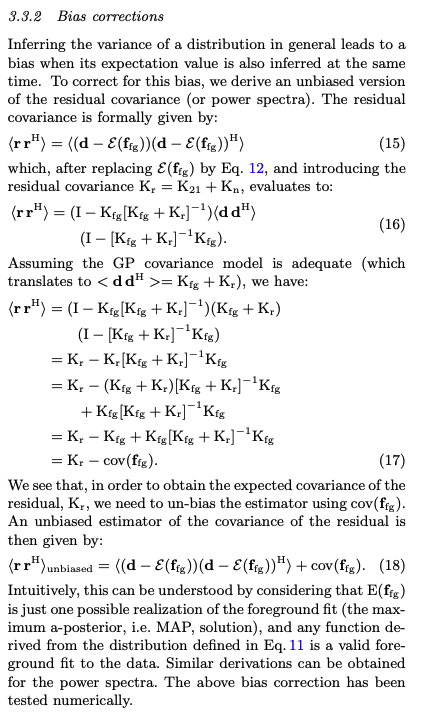

In [10]:
display.Image("images/bias_correction.png")

First, let's show that GPR recovers an expected value for the foregrounds which is in line with what we know the foregrounds look like.

In [11]:
# transform fg_fit and FGnopol_data from [Nx, Ny, Nx] --> [Nz, Npix] to calculate frequency covariance
fg_fit_los = obs.LoSpixels(fg_fit)
FGnopol_data_los = obs.LoSpixels(FGnopol_data)
# measuring frequency covariance of the GPR foreground expectation value, and of the input data:
C_fg_fit = np.cov(fg_fit_los)
C_input_fg = np.cov(FGnopol_data_los)

Next, we plot both (the actual foregrounds vs. the expected value obtained with GPR) to show that GPR recovers the foregrounds well. We plot on the top a few LoS sample, showing what a single pixel looks like along frequency, and on the bottom we plot the frequency covariance.

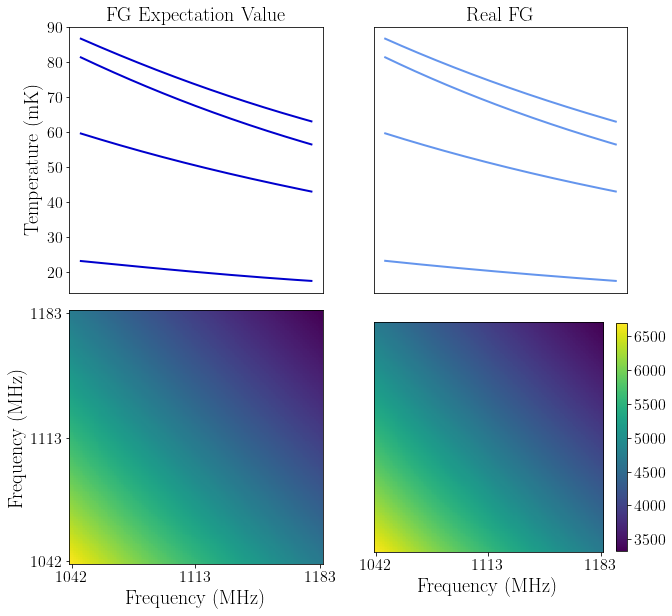

In [12]:
fig = plt.figure(figsize=(10,10))   # open a new plotting window

plt.subplot(221)
plt.plot(freqs, fg_fit_los[:,4444],lw=2, c='mediumblue')
plt.plot(freqs, fg_fit_los[:,444],lw=2, c='mediumblue')
plt.plot(freqs, fg_fit_los[:,44],lw=2, c='mediumblue')
plt.plot(freqs, fg_fit_los[:,4],lw=2, c='mediumblue')
plt.title('FG Expectation Value', fontsize=20)
plt.ylabel('Temperature (mK)', fontsize=20)
plt.xticks([])

plt.subplot(222)
plt.plot(freqs, FGnopol_data_los[:,4444],lw=2, c='cornflowerblue')
plt.plot(freqs, FGnopol_data_los[:,444],lw=2, c='cornflowerblue')
plt.plot(freqs, FGnopol_data_los[:,44],lw=2, c='cornflowerblue')
plt.plot(freqs, FGnopol_data_los[:,4],lw=2, c='cornflowerblue')
plt.title('Real FG', fontsize=20)
plt.xticks([])
plt.yticks([])

plt.subplot(223)
pos = plt.imshow(C_fg_fit, interpolation='nearest', origin='lower', cmap='viridis')
plt.xticks([1, 70, 140], [1042, 1113, 1183])
plt.yticks([1, 70, 140], [1042, 1113, 1183])
plt.xlabel('Frequency (MHz)', fontsize=20)
plt.ylabel('Frequency (MHz)', fontsize=20)

plt.subplot(224)
pos = plt.imshow(C_input_fg, interpolation='nearest', origin='lower', cmap='viridis')
fig.colorbar(pos, fraction=0.045)
plt.xticks([1, 70, 140], [1042, 1113, 1183])
plt.yticks([])
plt.xlabel('Frequency (MHz)', fontsize=20)

plt.subplots_adjust(hspace=0.04)

Now we move on to applying the bias correction to the residual covariance.

In [13]:
# calculating residual covariance:
C_res = np.cov(obs.LoSpixels(gpr_result.res, mean_center=False))
# applying bias correction:
C_res_corr = C_res + fg_cov
# calculating the real covariance from the input data:
C_input_21 = np.cov(obs.LoSpixels(HI_noise_data)[::-1])

Below we plot the uncorrected residual HI (and noise) frequency covariance, the bias corrected version, and the true HI + noise covariance for comparison. 

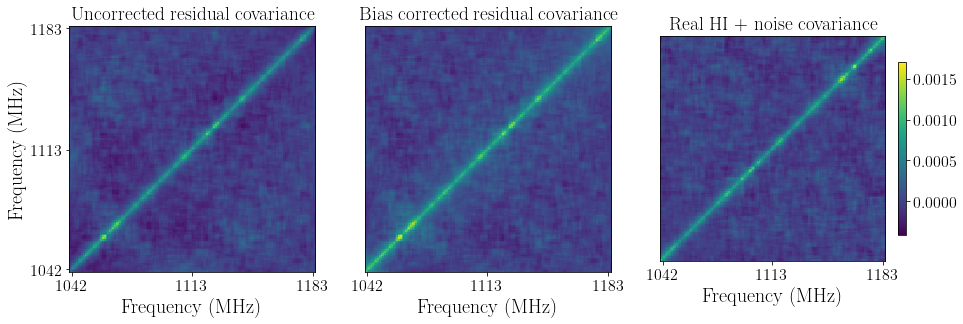

In [14]:
fig = plt.figure(figsize=(15,10))   # open a new plotting window

plt.subplot(131)
pos = plt.imshow(C_res, interpolation='nearest', origin='lower', cmap='viridis', vmin=-0.00041, vmax=0.0017)
plt.title('Uncorrected residual covariance')
plt.xticks([1, 70, 140], [1042, 1113, 1183])
plt.yticks([1, 70, 140], [1042, 1113, 1183])
plt.xlabel('Frequency (MHz)', fontsize=20)
plt.ylabel('Frequency (MHz)', fontsize=20)

plt.subplot(132)
pos = plt.imshow(C_res_corr, interpolation='nearest', origin='lower', cmap='viridis', vmin=-0.00041, vmax=0.0017)
plt.title('Bias corrected residual covariance')
plt.xticks([1, 70, 140], [1042, 1113, 1183])
plt.yticks([])
plt.xlabel('Frequency (MHz)', fontsize=20)

plt.subplot(133)
pos = plt.imshow(C_input_21, interpolation='nearest', origin='lower', cmap='viridis', vmin=-0.00041, vmax=0.0017)
fig.colorbar(pos, fraction=0.035)
plt.title('Real HI + noise covariance')
plt.xticks([1, 70, 140], [1042, 1113, 1183])
plt.yticks([])
plt.xlabel('Frequency (MHz)', fontsize=20)

plt.subplots_adjust(hspace=0.04)

Similarly to this bias correction to the residual covariance, there is a bias correction we must apply to the recovered residual power spectrum. We run through the power spectrum bias correction below.

## Approximate bias correction

### Step 1. Draw a lot of random realisation of the data described by the covariance of the foreground fit `fg_cov`

In [15]:
n_pix, n_freqs = Input.shape[0]*Input.shape[1], Input.shape[2]

mu = np.zeros(n_freqs) # vector of the means, zero
n_samples = 10 # number of samples we want to generate and later average over

# Generate n separate samples paths from a Gaussian with mean mu and covariance fg_cov:
samples = []
for i in range(n_samples):
    s = np.random.multivariate_normal(mu, fg_cov, (Input.shape[0], Input.shape[1]))
    samples.append(s)

samples = np.array(samples)

Let's compare these samples to the actual foreground residuals. They look similar in the LoS direction.

Text(0, 0.5, 'Temperature (mK)')

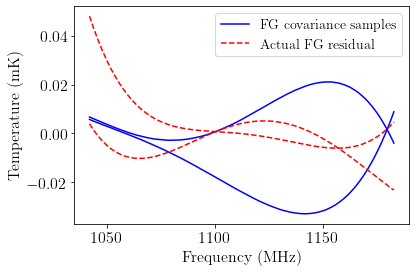

In [16]:
plt.plot(freqs, obs.LoSpixels(samples[5])[:,10], c='b', label='FG covariance samples')
plt.plot(freqs, obs.LoSpixels(samples[5])[:,2000], c='b')
plt.plot(freqs, obs.LoSpixels(fg_res)[:,10], ls='dashed', c='r', label='Actual FG residual')
plt.plot(freqs, obs.LoSpixels(fg_res)[:,200], ls='dashed', c='r')

plt.legend(fontsize=14)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (mK)')

Let's also compare the actual foreground residual data cube, to one of the FG covariance samples datacube. Since we've already compared the LoS component, we can now compare redshift slices. As seen below, __they do not look similar__. This is because when we generate the FG covariance samples, we only have the frequency covariance information, we have no spatial information in the transverse to the LoS direction, so the redshift slices are essentially random noise. 

The foreground residual on the other hand, has the transverse to the LoS information since we get it directly from the data.

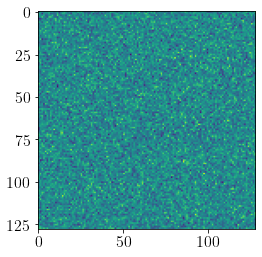

In [17]:
plt.imshow(samples[0][:,:,10])

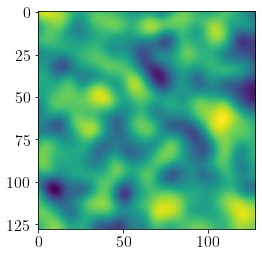

In [18]:
plt.imshow(fg_res[:,:,10])

To demonstrate this difference further, let's create a random sample using the covariance of the actual foreground residuals. We see that we get again only random noise in the transverse direction.

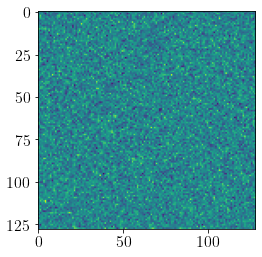

In [19]:
sample_fg_res = np.random.multivariate_normal(mu, fg_cov_actual, (Input.shape[0], Input.shape[1]))

plt.imshow(sample_fg_res[:,:,10])

Lets compare the power spectra of the approximate and actual bias corrections. We start by defining the k-bins for our power spectra. We look at the spherically averaged power spectrum, the transverse power spectrum, and the radial power spectrum.

In [20]:
# Dimension of data cube:
lx,ly,lz = 500, 500, 460.77 #Mpc/h
nx,ny,nz = 128, 128, 142
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmin_perp = 2*np.pi/np.sqrt(lx**2 + ly**2)
kmin_par = 2*np.pi/lz
kmax = 0.5
kmax_par= 0.5
kmax_perp = 0.5

# set width of k bins to be 2*kmin
dk = 2*kmin
dk_perp = 2*kmin_perp
dk_par = 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

### Step 2. Measure the power spectra of our samples

Namely the spherically averaged power spectrum, the radial power spectrum, and the transverse power spectrum.

In [21]:
pk_corr = []
pk_corr_para = []
pk_corr_perp = []

for s in samples:
    pk_corr.append(pk.getpk(s,w,W,nx,ny,nz,lx,ly,lz,kbins)[0])
    pk_corr_para.append(pk.ParaPk(s, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0])
    pk_corr_perp.append(pk.PerpPk(s, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0])

### Step 3. Average these power spectra

In [22]:
pk_corr = np.mean(pk_corr, axis=0)
pk_corr_para = np.mean(pk_corr_para, axis=0)
pk_corr_perp = np.mean(pk_corr_perp, axis=0)

Measuring the same power spectra for the actual bias correction (`fg_res`):

In [23]:
pk_truecorr = pk.getpk(fg_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_truecorr_para = pk.ParaPk(fg_res, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
pk_truecorr_perp = pk.PerpPk(fg_res, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

Plotting all the power spectra in order to compare these two bias corrections:

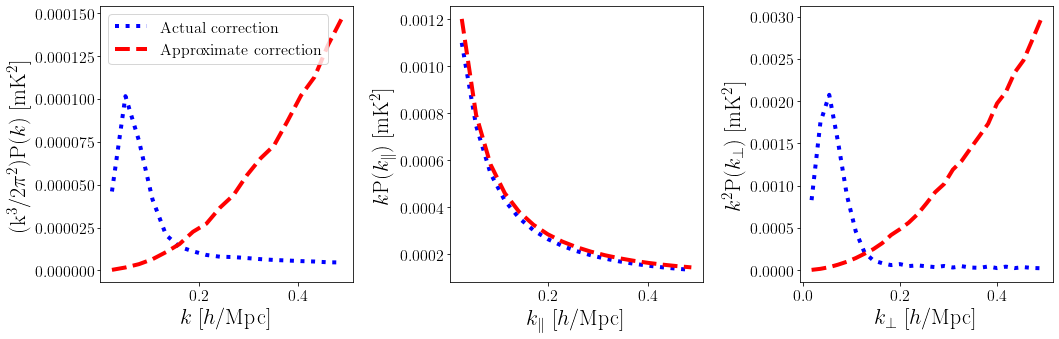

In [24]:
fig = plt.figure(figsize=(15,5))   # open a new plotting window

plt.subplot(131)
plt.plot(k, (k*k*k*pk_truecorr)/(2*np.pi*np.pi), lw=4, ls='dotted', c='b', label="Actual correction")
plt.plot(k, (k*k*k*pk_corr)/(2*np.pi*np.pi), lw=4, ls='dashed', c='r', label='Approximate correction')
plt.legend()
plt.xlabel('$k$ [$h$/Mpc]', fontsize=22)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)

plt.subplot(132)
plt.plot(kpar, kpar*pk_truecorr_para, lw=4, ls='dotted', c='b', label="Analytic correction")
plt.plot(kpar, kpar*pk_corr_para, lw=4, ls='dashed', c='r', label='Actual correction')
plt.xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=22)
plt.ylabel('$k$P($k_\parallel$) [mK$^2$]', fontsize=22)

plt.subplot(133)
plt.plot(kperp, kperp*kperp*pk_truecorr_perp, lw=4, ls='dotted', c='b', label="Analytic correction")
plt.plot(kperp, kperp*kperp*pk_corr_perp, lw=4, ls='dashed', c='r', label='Actual correction')
plt.xlabel('$k_\perp$ [$h$/Mpc]', fontsize=22)
plt.ylabel('$k^2$P($k_\perp$) [mK$^2$]', fontsize=22)

plt.tight_layout()

It's clear from this that our approximate bias correction is a good approximation for the actual bias correction *only in the parallel to the LoS direction*. This makes sense physically an intuitively: We generate our approximate bias correction by sampling from our foreground error covariance - this covariance is *only a function of frequency*, therefore gives us no spatial information. All of the spatial information in the perpentidular direction is just random noise, as we saw. __We do not want to add this random noise to our residual power spectrum, as this random noise is not a physically motivated correction, but instead a product of our Gaussian realisations__.

It's also interesting to note that a lot of the power from the actual correction is coming from the perpendicular direction, possibly because GPR is not as good at removing foregrounds there since it acts in the parallel (frequency) direction.

### Step 4. Add the averaged power spectrum to 2D residual power spectrum, only in the parallel direction:

We only want to add our approximate bias correction in the LoS direction, so when we calculate its spherically averaged power spectrum we set the perpendicular modes to zero. We do this by calculating the spherically averaged power spectrum using the function `getpk_noPerp`, which ignores the transverse component.

In [25]:
pk_corr_noPerp = []

for s in samples:
    pk_corr_noPerp.append(pk.getpk_noPerp(s,w,W,nx,ny,nz,lx,ly,lz,kbins)[0])
        
pk_corr_noPerp = np.mean(pk_corr_noPerp, axis=0) # averaging over all of them

Alternatively, all of the steps outlined above (1-4) can be accomplished by calling the function `get_biascorr` which does the bias correction for you. You need to input your foreground error covariance `fg_cov`, as well as your original data `Input` and how many samples you want the generate `n_samples`. You get back `pk3d_corr` which is equivalent to `pk_corr_noPerp`, while `pk1d_corr` is the correction to the LoS power spectrum only. `samples` are the randomly generated samples from the foreground fit covariance `fg_cov`.

In [26]:
pk3d_corr, pk1d_corr, samples = pk.get_biascorr(fg_cov, Input, n_samples, lx, ly, lz, kbins_par, kbins, w, W)

Measure the true and residual HI power spectra, and add corrections:

In [27]:
# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# residual power spectrum:
res_pk = pk.getpk(gpr_result.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# applying approximate bias correction:
res_pk_corr = res_pk + pk_corr_noPerp

# applying actual bias correction:
res_pk_truecorr = res_pk + pk_truecorr

Text(0.5, 0, 'k [$h$/Mpc]')

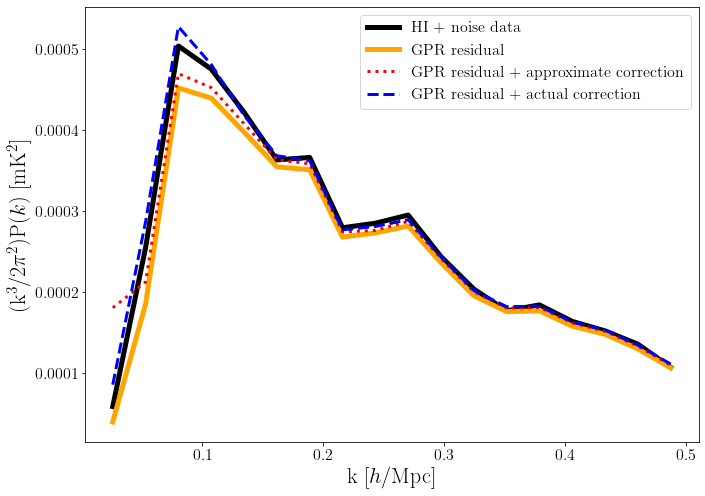

In [28]:
plt.figure(figsize=(11,8))
plt.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi),ls='solid', c='k', lw=5, label = r'HI + noise data')
plt.plot(k, (k*k*k*res_pk)/(2*np.pi*np.pi),ls='solid', c='orange', lw=5, label = r'GPR residual')
plt.plot(k, (k*k*k*res_pk_corr)/(2*np.pi*np.pi),ls='dotted',c='r', lw=3, label = r'GPR residual + approximate correction')
plt.plot(k, (k*k*k*res_pk_truecorr)/(2*np.pi*np.pi),ls='dashed',c='b', lw=3, label = r'GPR residual + actual correction')

plt.legend(fontsize=16)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)
plt.xlabel('k [$h$/Mpc]', fontsize=22)

The effect of the approximate bias correction (along the LoS only) is overall small (except on largest scales), while the actual correction has a larger effect, probably since it takes into account spatial information.